In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
leiden=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/leidenA.csv')
k3=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/clust_3kA.csv')
comp=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/clusterv_compA.csv')
clust2=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/clusterv2A.csv').merge(leiden[['eid']])
dftot = pd.read_csv('/Users/Evelyn/Documents/UKB/materials/3k_prot_v1.csv').iloc[:,:-2].merge(leiden[['eid']])
df = pd.read_csv('/Users/Evelyn/Documents/UKB/materials/3kprot_all_expression_new.csv')
outcomelong=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/outcomelong.csv').merge(leiden[['eid']])

In [4]:
# Recreate clusters based on protein abundance
def recreate(scale, prot_list, inclust_people, disease_name, total_sick, total_people, percentage_num, level=None):
    tempdf = dftot[['eid']+prot_list].dropna()
    # Calculate the quantile
    quantiles = {}     
    for prot in prot_list:
        quantiles[prot] = {}
        if level is None:
            loop_range = range(0, percentage_num)
            for i in loop_range:
                a = i / 100
                quantiles[prot][a] = inclust_people[prot].quantile(a)
        else:
            loop_range = range(100, percentage_num, -1)   
            for i in loop_range:
                a = i / 100
                quantiles[prot][a] = inclust_people[prot].quantile(a)
        num_quantiles = len(loop_range)

    # Analysis of all proteins  
    diction = {}
    all_rows = []
    for i in loop_range:
        a = i / 100
        tempdf_new = tempdf.copy()
        for prot in prot_list:
            l = quantiles[prot][a]
            if level is None:
                tempdf_new = tempdf_new[tempdf_new[prot] > l]
            else:
                tempdf_new = tempdf_new[tempdf_new[prot] < l]             
        had_disease = tempdf_new[['eid']].merge(outcomelong, on='eid', how='left')
        had_disease = (had_disease[disease_name] == 1).values
        people = len(tempdf_new['eid'])
        sick_count = int(had_disease.sum())
        if people == 0:
            ratio1 = 0
            ratio2 = 0
        else:
            ratio1 = (sick_count / people) * 100
            ratio2 = (sick_count / people) / (total_sick / total_people)
        all_rows.append((a, people, sick_count, ratio1, ratio2))
    
    for idx in range(len(all_rows)):
        a, people, sick_count, ratio1, ratio2 = all_rows[idx]
        if people > 0:
            try:
                contingency_table = [[sick_count, people - sick_count],[total_sick, total_people - total_sick]]
                _, raw_p, _, _ = chi2_contingency(contingency_table)
                corrected_p = min(raw_p * num_quantiles, 1.0)
                p_value = corrected_p
            except:
                p_value = np.nan
        else:
            p_value = np.nan
        diction[a] = (people, sick_count, '{:.2f}%'.format(ratio1), ratio2, p_value)    
    mydf = pd.DataFrame.from_dict(diction, orient='index', columns=['all_prot', 'sick_count', 'sick_percentages', 'OR', 'p_value'])
    mydf.rename(columns={'index': 'key'}, inplace=True)

    # Analysis after removing a protein
    all_data = []
    prot_names = [] 
    for col in range(1, len(prot_list) + 1):
        prot = tempdf.columns[col]
        prot_names.append(prot)
        temp = tempdf.drop(tempdf.columns[col], axis=1)
        prot_rows = []
        for i in loop_range:
            a = i / 100
            tempdf_new = temp.copy()
            for prot in temp.columns.tolist()[1:]:
                l = quantiles[prot][a]
                if level is None:
                    tempdf_new = tempdf_new[tempdf_new[prot] > l]
                else:
                    tempdf_new = tempdf_new[tempdf_new[prot] < l]     
            had_disease = tempdf_new[['eid']].merge(outcomelong, on='eid', how='left')
            had_disease = (had_disease[disease_name] == 1).values
            people = len(tempdf_new['eid'])
            sick_count = int(had_disease.sum())
            if people == 0:
                ratio1 = 0
                ratio2 = 0
            else:
                ratio1 = (sick_count / people) * 100
                ratio2 = (sick_count / people) / (total_sick / total_people)
            prot_rows.append((a, people, sick_count, ratio1, ratio2))
        prot_dict = {}
        for idx in range(len(prot_rows)):
            a, people, sick_count, ratio1, ratio2 = prot_rows[idx]
            
            if people > 0:
                try:
                    contingency_table = [[sick_count, people - sick_count],[total_sick, total_people - total_sick]]
                    _, raw_p, _, _ = chi2_contingency(contingency_table)
                    corrected_p = min(raw_p * num_quantiles, 1.0)
                    p_value = corrected_p
                except:
                    p_value = np.nan
            else:
                p_value = np.nan
            prot_dict[a] = (people, sick_count, '{:.2f}%'.format(ratio1), ratio2, p_value)
        data = pd.DataFrame.from_dict(prot_dict, orient='index')
        all_data.append(data)
        
    # Create table
    concat_df = pd.concat(all_data, axis=1)
    mydf2 = pd.DataFrame(concat_df)
    new_names = []
    for name in prot_names:
        new_names.extend([f'{name}_{i}' for i in ['deleted','sick_count','sick_percentages','OR','p_value']])
    mydf2.columns = new_names    
    result_df = pd.concat([mydf, mydf2], axis=1)

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    OR_column = len(prot_list) * 5
    y_list = []
    for y in range(8, OR_column, 5):
        ax.plot(result_df.index, result_df.iloc[:, y], alpha=0.3, linewidth=0.8, linestyle='-', color='#949494')
        y_list += [result_df.iloc[:, y].astype(float).to_numpy()] 
    ax.plot(result_df.index, result_df.iloc[:, 3], linewidth=1,  linestyle='-', color='darkred', label='All proteins', zorder=10)
    ax.plot([], [], linewidth=1.5, linestyle='-', color='#949494', label='Remove a protein'  )

    if level is not None:
        ax.invert_xaxis()
    x = result_df.index.astype(float).to_numpy()
    y_min = np.min(y_list, axis=0)   
    y_max = np.max(y_list, axis=0)
    ax.fill_between(x, y_min, y_max, color='darkblue', alpha=0.2)
    ax.set_xlabel('Quantile')
    ax.set_ylabel('Odds ratio') 
    plt.show()

    return fig

## Figure3 B

In [5]:
# Common proteins in celiac clusters
c1 = df[(df['file']=='comp')&(df['cluster']=='cl2')]
c2 = df[(df['file']=='comp')&(df['cluster']=='cl3')]
c3 = df[(df['file']=='3k')&(df['cluster']=='cl6')]
c4 = df[(df['file']=='leiden')&(df['cluster']=='cl7')]
celi_prot = list(set(c1['protein']).intersection(c2['protein']).intersection(c3['protein']).intersection(c4['protein']))

In [6]:
# Participants in celiac clusters
ince1 = comp[comp['cl2']==1]
ince2 = comp[comp['cl3']==1]
ince3 = k3[k3['cl6']==1]
ince4 = leiden[leiden['cl7']==1] 
incl_celi = ince1[['eid']].merge(ince2[['eid']], how='outer').merge(ince3[['eid']], how='outer').merge(ince4[['eid']], how='outer')
incl_celi_dftot = incl_celi.merge(dftot,on='eid',how='left')

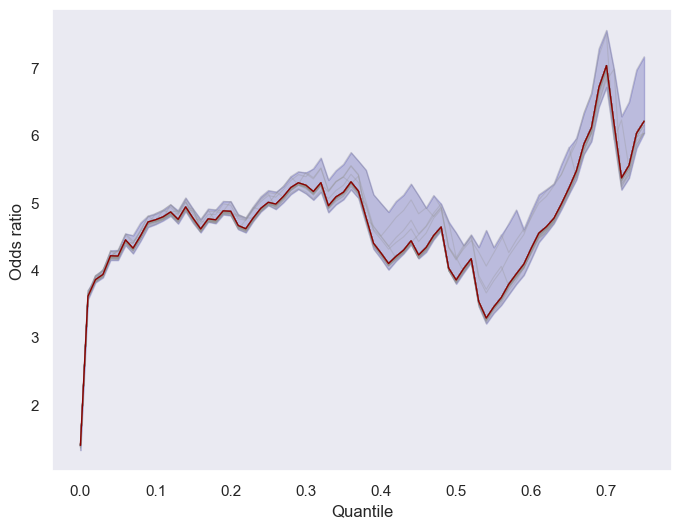

In [11]:
sns.set_theme(style="dark")
fig = recreate('a_to_1', celi_prot, incl_celi_dftot, 'K90 Intestinal malabsorption', 357,45174, 76)
fig.savefig('celiac.png', dpi=1000, bbox_inches='tight')

## Figure3 C,D

In [13]:
# Common proteins in hypertension clusters
hy1 = df[(df['file']=='leiden')&(df['cluster']=='cl1')] 
hy2 = df[(df['file']=='leiden')&(df['cluster']=='cl2')] 
hy3 = df[(df['file']=='leiden')&(df['cluster']=='cl5')] 
hy4 = df[(df['file']=='leiden')&(df['cluster']=='cl6')]
hyp_prot = list(set(hy1['protein']).intersection(hy2['protein']).intersection(hy3['protein']).intersection(hy4['protein']))

In [14]:
# Participants in hypertyension clusters
inhy1 = leiden[leiden['cl1']==1] 
inhy2 = leiden[leiden['cl2']==1] 
inhy3 = leiden[leiden['cl5']==1] 
inhy4 = leiden[leiden['cl6']==1] 
incl_hyp = inhy1[['eid']].merge(inhy2[['eid']], how='outer').merge(inhy3[['eid']], how='outer').merge(inhy4[['eid']], how='outer')
incl_hyp_dftot = incl_hyp.merge(dftot,on='eid',how='left')

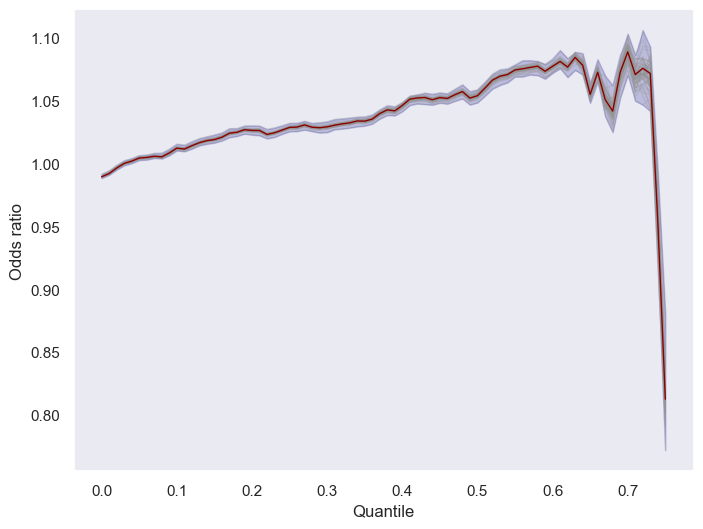

In [ ]:
sns.set_theme(style="dark")
fig1 = recreate('a_to_1', hyp_prot, incl_hyp_dftot,'I10 Essential (primary) hypertension' ,14996, 45174 , 76)
fig2 = recreate('a_to_0', hyp_prot, incl_hyp_dftot, 'I10 Essential (primary) hypertension', 14996, 45174, 24, level='low')
fig1.savefig('hypert_pca_high.png', dpi=1000, bbox_inches='tight')
fig2.savefig('hypert_pca_low.png', dpi=1000, bbox_inches='tight')

## Figure3 E

In [ ]:
# Common proteins in leukemia clusters
l1 = df[(df['file']=='comp')&(df['cluster']=='cl5')]
l2 = df[(df['file']=='comp')&(df['cluster']=='cl7')]
l3 = df[(df['file']=='cluster2')&(df['cluster']=='cl1')]
l4 = df[(df['file']=='cluster2')&(df['cluster']=='cl5')]
l5 = df[(df['file']=='3k')&(df['cluster']=='cl16')]
l6 = df[(df['file']=='leiden')&(df['cluster']=='cl10')]
leuk_prot = list(set(l1['protein']).intersection(l2['protein']).intersection(l3['protein']).intersection(l4['protein']).intersection(l5['protein']).intersection(l6['protein']))

In [ ]:
# Participants in leukemia clusters
inle1 = comp[comp['cl5']==1]
inle2 = comp[comp['cl7']==1]
inle3 = clust2[clust2['cl1']==1]
inle4 = clust2[clust2['cl5']==1]
inle5 = k3[k3['cl16']==1]
inle6 = leiden[leiden['cl10']==1] 
incl_leuk = inle1[['eid']].merge(inle2[['eid']], how='outer').merge(inle3[['eid']], how='outer').merge(inle4[['eid']], how='outer').merge(inle5[['eid']], how='outer').merge(inle6[['eid']], how='outer')
incl_leuk_dftot = incl_leuk.merge(dftot,on='eid',how='left')

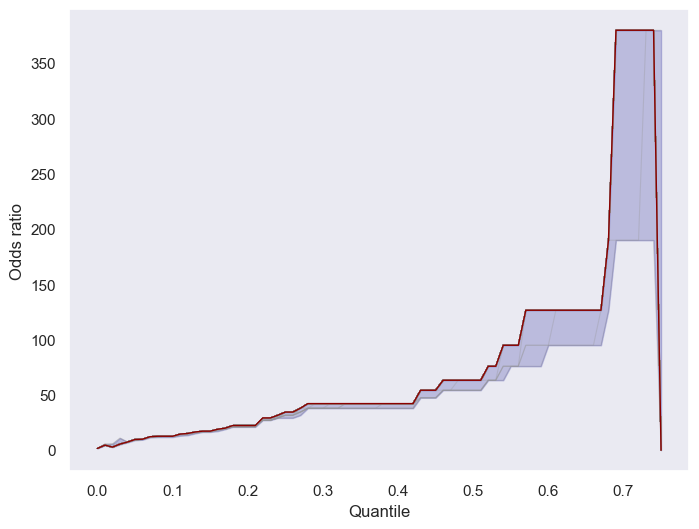

In [18]:
sns.set_theme(style="dark")
fig = recreate('a_to_1', leuk_prot, incl_leuk_dftot, 'C91 Lymphoid leukaemia', 119,45174, 76, dftot)
fig.savefig('Fig3_E.png', dpi=1000, bbox_inches='tight')